# Engineering Notebook Final Project

Goal: develop a replicated, distributed database system which supports both strongly consistent data and eventually consistent data. The idea is that writes and reads can be directed to any of the replicated databases, with consistency guarantees only for those tables/columns marked as strongly consistent.

Challenges brainstorm:
- We need to use non-sequenced primary keys to make sure that foreign keys can be made to work
- At what level do we implement the consistency requirements? Do we just create separate servers, each with their own database, that receive instructions via sockets?
- Queries that involve columns/tables of mixed consistency requirements are difficult
- Do we send the replication before or after the commit on the first replica? -> Has to be before to avoid rolling back a transaction
- Can every replica initiate a strongly consistent transaction or do we have a leader to whom those transactions are forwarded?
    - Edge case: a strongly consistent column only gets changed by `onupdate` (or `default`), especially bad in case where this is a timestamp (now why would you ever do that, I'm not sure)
- How can we do Python defaults at a transaction level (e.g. set the CURRENT_TIMESTAMP to be the same for all objects in a transaction without going back and forth to the database)?
- How can we make sure that only the columns/tables affected by a transaction are "locked" for the duration of a strong transaction?

If strongly consistent, need to get the majority/everyonen on board; then 
Weakly consistent; store locally; then pass onto all other replicas on whatever time we want; 

if we read from a strongly consistent thing; we have to also ask the leader; who will inform if it is still in the process of informing all replicas that a strongly consistent write is happening. 

what happens if you send the same transaction twice or to multiple machines; there should be a log on that machine if it did not go down or a different machine that is still up that help check if the thing has already been done it does not get done twice. 

leader election; the config.json file specifies possible ports; having one leader; if it goes down sometime then the first machine that detects this send a message starting from the machine with the lowest port number; and it gets elected as the leader. 


Load Balancer: not sure for now; think later

### April 19
- From a point of abstraction, the API should not be aware that it is dealing with multiple database replicas. So we either need to implement a separate `Session` class which monitors all read and write statements, and then sets the database accordingly, but this will also have to implement some consensus logic, which definitely shouldn't be a part of the API's code at all
- Alternative: instead of using a full SQL server, for now, build a very simple relational database ourselves, so that we can intercept all queries easily
    - We could re-use part of our wire protocol to convert from and to binary data
    - Potential complexity: transactions, subqueries, etc.; importantly, we'd also need to write a simple query language and parse it
    - If we restrict ourselves to only using insert, update, delete, and maybe begin/commit, we can already do a lot (but for example no foreign keys, multiple indexes, complex filters, etc.), and we could implement this using a REST API with GET, PATCH, POST requests for simplicity
- Second alternative: build a proxy database server through which all of the requests pass, and which forwards most of them
    - Complexities: this proxy will need to do a lot of parsing

### April 22
- Okay idk why I thought we need to build a whole database system from scratch (it was kinda fun doing this though) but we can just create a proxy which uses its own simple language but then a regular SQL database underneath
- For now, let's use a REST API but we can probably convert that to sockets for a little extra performance
- Next steps: implement the proxy with an outside interface for sending queries, and an inside interface for taking care of the communication between replicas
- Also, do we actually need to do strong select queries?
    - If we only require a majority (e.g. Raft), then yes (could there be a case where a replica which doesn't respond/agree drops that request and then takes a read request?)
    - If we require unanimous agreement, then no, since in that case all replicas would have been updated by the time that the client sends a read request
    - Generally: always problems with temporary partition failure, even with unanimous agreement

### April 23
- We need to send clock values along with every strong query for synchronization
- We don't need to check if the followers *accept* the query (since if the leader can do it, they should all be able to do it), but rather just confirm that they have done it
- Defaults and onupdate functions need to be implemented by the client connecting to the database (e.g. the API)

### April 25
- This parsing is actually a much bigger pain than I thought it would be; if we use a proxy, the problem is that Postgres for example uses some type of SSL encryption at the beginning to make the connection and the password transmission secure which is really annoying to take care of; if we use middleware, then the problem is that SQL uses relations to make the reference to objects easier and more efficient but this means that we can't just switch from one server to another because that would mean that we send information about relations which the database doesn't know about because we haven't established what that relation means (with that specific database). Now, we could just also transmit relation IDs but then the problem is that those are probably only unique within a specific session between one client and one database, and so there could be clashes and ambiguity
- So basically I think that unfortunately, just doing the whole separate, simpler REST protocol will be much easier

### April 26
- It is still an open problem in our code when a replica crashes between having implemented a query and returning the acceptance (this is why Raft does proposals and commits with a majority)


### April 29
- Our proxy needs to implement defaults and onupdates somehow
- As another challenge, for weak transactions, there is currently not really a guarantee that they will be eventually consistent at all: if we have two update queries with different values happening at the same time, they will just end up in an inconsistent state, since both replicas commit them to their own version, then they receive the others' version, and update again. If we want to avoid this, we need to keep track of a commit history for each *field* in our database along with operations, timestamps, and old + new values.
- This is probably what we actually want lol

### April 30
- Open ToDos
    - Bring new replicas up to date on the eventual log (this could be a kind of distributed binary tree search with a Merkle tree of the transaction hashes)
    - Conflict resolution and retries upon conflicts in weak queries
    - Testing!!

### May 1
- One problem when stress-testing with strong queries appears to be that the connection between replicas becomes a bottleneck
- Nasty race condition: the leader can implement a strong query, update its clock, then send a handshake to the follower (who becomes a learner), and only then forwards the queue to process
- Another issue: if we receive two operations at once, we would previously only parse one and then wait until the next one came in such that we're always one request behind -> this creates issues
    - Solution to this: just work off *all* available requests for every readable socket at once; this could create some issues with ordering since all operations are started as separate threads but it appears as though it hasn't caused any issues yet; it could also be a problem if one replica just bombards another with requests and takes up all of its time (or if clock speeds are very different).

### May 2
- We want to be able to orchestrate the replication cluster nicely, also for testing
- Move to Docker solution, where Docker containers find each other using DNS, with load balancer (bottleneck!) that round-robins the requests to the online replicas

### May 3
- What do we do when a strong query can be executed by the leader but the leader doesn't get the necessary responses from the followers? We should be able to roll back the transaction in that case
- Evaluations from running `evaluate.py`

In [7]:
### Request Performances with 5 replicas (in ms / request)
### Single-threaded requests (1 worker)
ST5 = {
    "get_users": 3.2080390453338623,
    "get_posts": 8.256486177444458,
    "create_user": 55.30728507041931,
    "create_user_and_posts": 128.48273301124573 / 11,
    "create_post": 7.182924032211304,
    "update_user_name": 8.378488779067993,
    "update_user_username": 57.330739974975586,
    "update_post_content": 8.543267965316772,
    "delete_user": 54.50702619552612,
    "delete_post": 6.685853958129883,
}

### Multi-threaded requests (100 workers)
MT5 = {
    "get_users": 0.8462369441986084,
    "get_posts": 2.1026360988616943,
    "create_user": 57.1283540725708,
    "create_user_and_posts": 61.76777911186218 / 11,
    "create_post": 1.4762470722198486,
    "update_user_name": 1.8972489833831787,
    "update_user_username": 57.63353896141052,
    "update_post_content": 1.896394968032837,
    "delete_user": 56.267510175704956,
    "delete_post": 1.6434223651885986,
}

In [8]:
### Request Performances with 3 replicas (in ms / request)
### Single-threaded requests (1 worker)
ST3 = {
    "get_users": 3.406291961669922,
    "get_posts": 8.204491138458252,
    "create_user": 52.22210383415222,
    "create_user_and_posts": 117.61377191543579 / 11,
    "create_post": 5.524569749832153,
    "update_user_name": 7.258277893066406,
    "update_user_username": 54.77264404296875,
    "update_post_content": 6.961857080459595,
    "delete_user": 51.09874105453491,
    "delete_post": 5.447628021240234,
}
### Multi-threaded requests (100 workers)
MT3 = {
    "get_users": 0.9188048839569092,
    "get_posts": 2.0419249534606934,
    "create_user": 52.811911821365356,
    "create_user_and_posts": 46.93812894821167 / 11,
    "create_post": 1.6898527145385742,
    "update_user_name": 2.1914889812469482,
    "update_user_username": 49.79168081283569,
    "update_post_content": 2.2476253509521484,
    "delete_user": 51.469698905944824,
    "delete_post": 2.085291862487793,
}

In [9]:
### Request Performances with 1 replica (in ms / request)
### Single-threaded requests (1 worker)
ST1 = {
    "get_users": 3.160005807876587,
    "get_posts": 7.829870939254761,
    "create_user": 4.838819742202759,
    "create_user_and_posts": 45.59628200531006 / 11,
    "create_post": 4.080101013183594,
    "update_user_name": 6.300812005996704,
    "update_user_username": 6.98828125,
    "update_post_content": 6.408214092254639,
    "delete_user": 4.251584053039551,
    "delete_post": 4.1334428787231445,
}
### Multi-threaded requests (100 workers)
MT1 = {
    "get_users": 1.3063197135925293,
    "get_posts": 4.2999889850616455,
    "create_user": 6.3092100620269775,
    "create_user_and_posts": 27.55797290802002 / 11,
    "create_post": 2.255181074142456,
    "update_user_name": 2.981278896331787,
    "update_user_username": 7.187427759170532,
    "update_post_content": 3.009586811065674,
    "delete_user": 5.916057109832764,
    "delete_post": 2.2624270915985107,
}

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df_st = pd.DataFrame({
    1: ST1,
    3: ST3,
    5: ST5,
})

df_mt = pd.DataFrame({
    1: MT1,
    3: MT3,
    5: MT5,
})

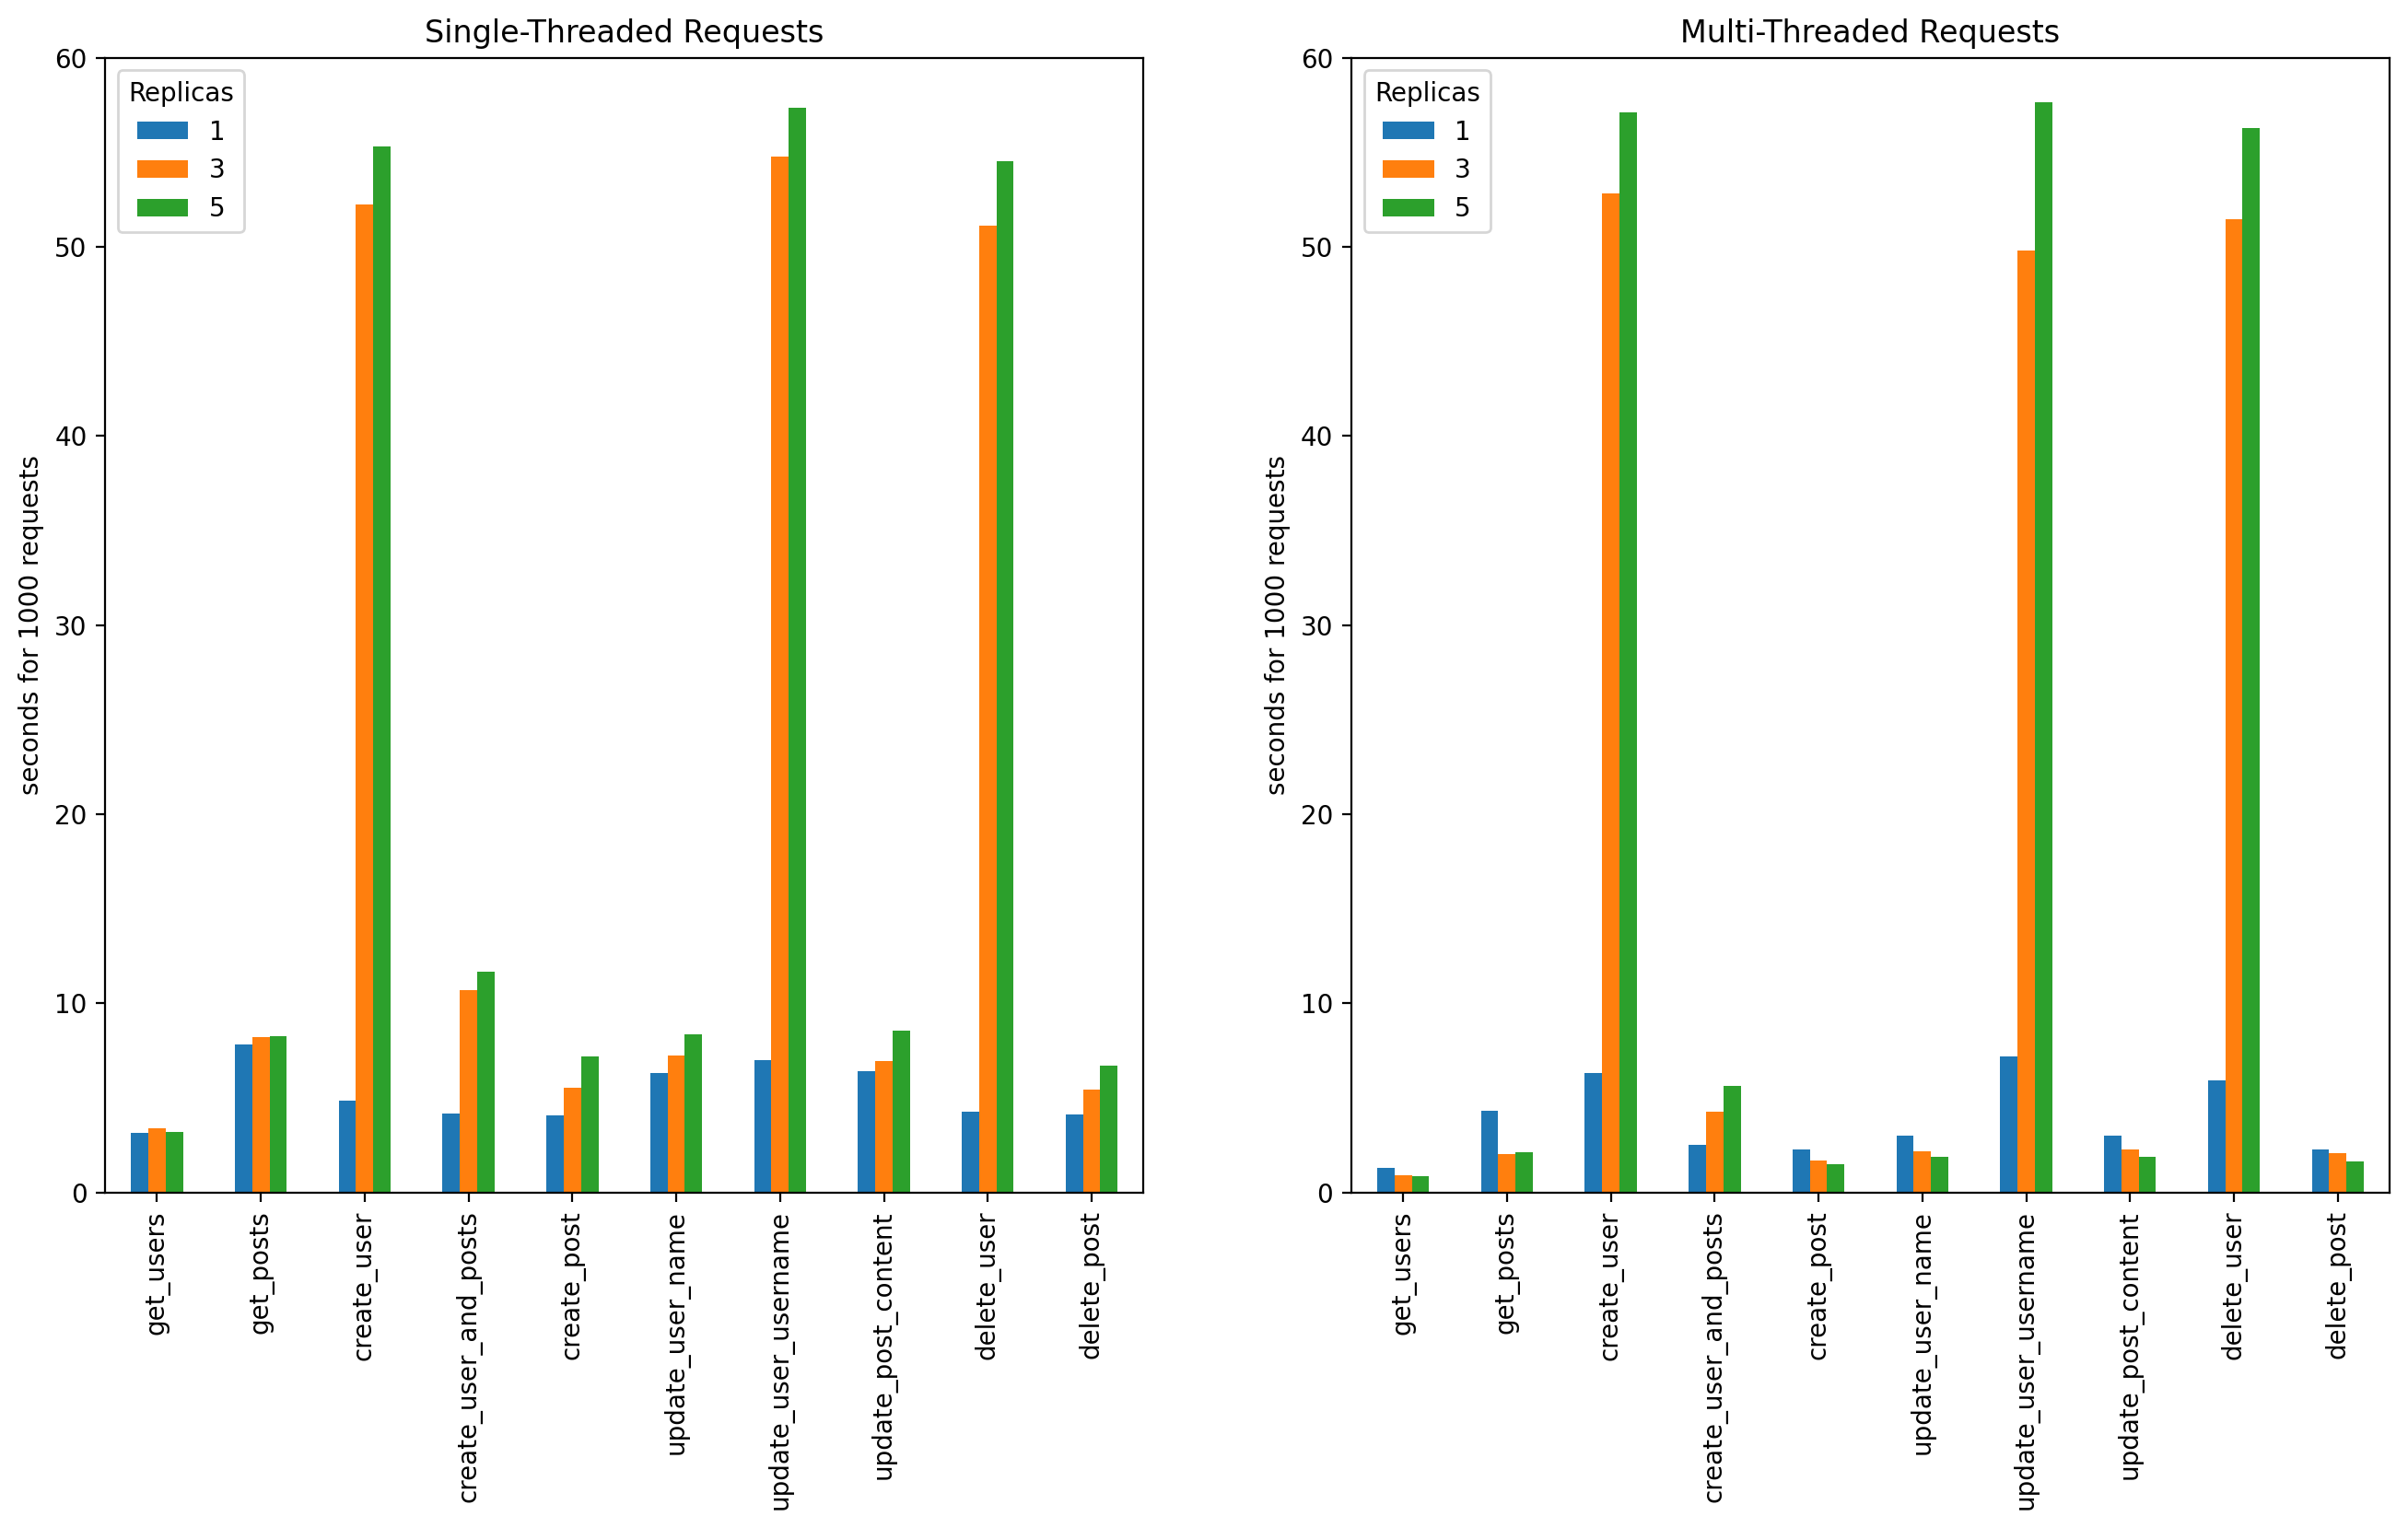

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8), dpi=200)

df_st.plot(ax=ax[0], kind="bar")
df_mt.plot(ax=ax[1], kind="bar")

# ax[0].set_yscale("log")
# ax[1].set_yscale("log")

ax[0].set_ylim(0, 60)
ax[1].set_ylim(0, 60)

ax[0].set_title("Single-Threaded Requests")
ax[1].set_title("Multi-Threaded Requests")

ax[0].set_ylabel("seconds for 1000 requests")
ax[1].set_ylabel("seconds for 1000 requests")

ax[0].legend(title="Replicas")
ax[1].legend(title="Replicas")

fig.savefig("evaluations.pdf", bbox_inches="tight")

- The queries involving strong columns are *much* slower since we deliberately bottleneck them through the leader. In the future, to speed things up (especially with multithreading), we could think about more fine-grained locking of the database and the proxy to handle unrelated strong queries simultaneously